In [23]:
from time import sleep
from os import chdir, mkdir
from os.path import isdir, isfile

try:
    chdir(r'A:\_Projetos\AnotacoesEstudosBackPythonLSP\Home\acoes')
except:
    chdir(r'C:\Users\GOMEE11\Documents\_Referencias\Git\AnotacoesEstudosBackPythonLSP\Home\acoes')

for d in ['.\\Graph', '.\\Tables']:
    if isdir(d):
        pass
    else:
        mkdir(d)
        pass

from matplotlib import pyplot as plt
import pandas as pd
from pandas_datareader import DataReader as wb
import numpy as np
from make_data import Down_Data, Analisys, Graph
import datetime

try:
    from selenium import webdriver
    selenium = True
    fundSite = 'http://www.fundamentus.com.br/detalhes.php?papel='
    xpath_price = '/html/body/div[1]/div[2]/table[1]/tbody/tr[1]/td[4]'
    xpath_lpa = '/html/body/div[1]/div[2]/table[3]/tbody/tr[2]/td[6]'
    xpath_vpa = '/html/body/div[1]/div[2]/table[3]/tbody/tr[3]/td[6]'
    xpath_numero_acoes = '/html/body/div[1]/div[2]/table[2]/tbody/tr[2]/td[4]'
    xpath_patrimonio_liquido = '/html/body/div[1]/div[2]/table[4]/tbody/tr[4]/td[4]'
    pass
except:
    pass

plt.style.use('seaborn-dark')
# plt.style.available

%matplotlib inline

# Analise individual de Ticker

### Analise Técnica

In [10]:
# Indice Bovespa para Comparação

indice_bovespa = wb('^BVSP', data_source='yahoo', start='2018-1-1')['Adj Close']
indice_bovespa_returns = (indice_bovespa / indice_bovespa.shift(1)) - 1
indice_bovespa_annual_returns = indice_bovespa_returns.mean() * 250

In [83]:
ticker = 'CTSA3'

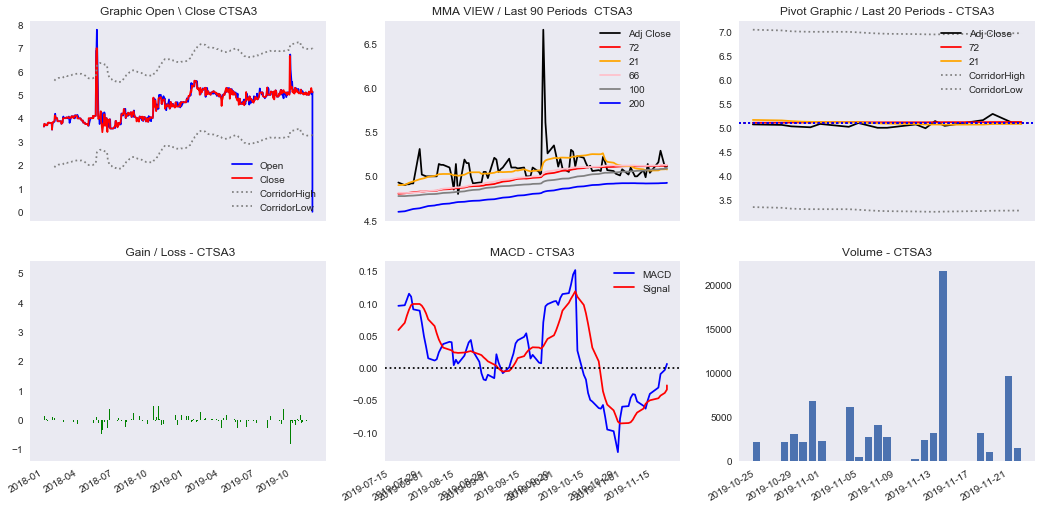

In [84]:
target = Down_Data(ticker)
analise = Analisys(target, ticker)
graph = Graph(target, ticker)


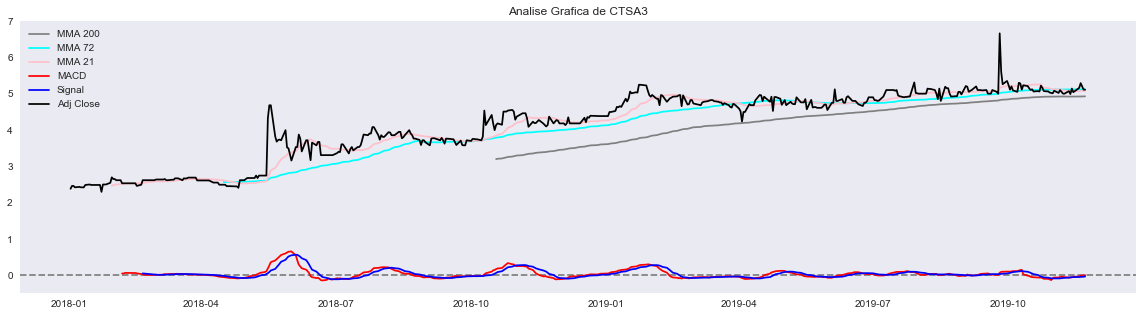

In [85]:
plt.figure(figsize=(20, 5))

plt.plot(analise['MMA200'], color='Grey', label='MMA 200')
plt.plot(analise['MMA72'], color='Cyan', label='MMA 72')
plt.plot(analise['MMA21'], color='Pink', label='MMA 21')

plt.axhline(0, color='Grey', linestyle="--")

plt.plot(analise['MACD'], color='Red', label='MACD')
plt.plot(analise['Signal'], color='Blue', label='Signal')

plt.plot(analise['Adj Close'], color='Black', label='Adj Close')

plt.title(f'Analise Grafica de {ticker}')

plt.legend()

plt.show()

## Análise de Risco
### Taxa de Retorno

Taxa de retorno Anual de (CTSA3) : 62.56606% / Bovespa : 19.84932%


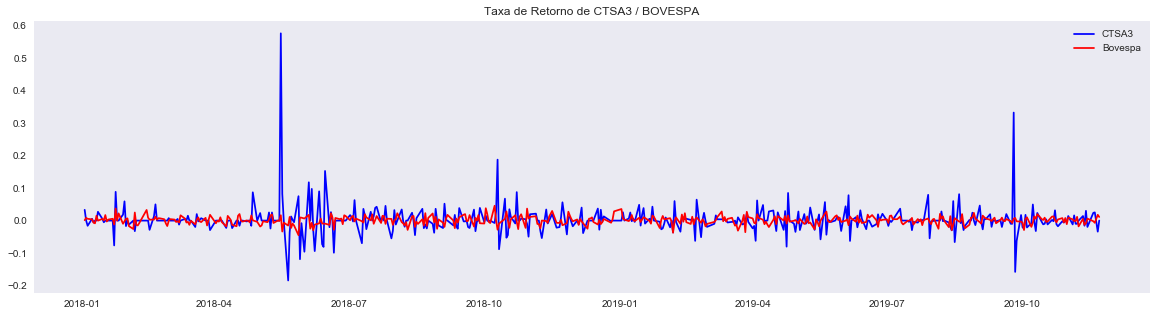

In [93]:
returns = (analise['Adj Close'] / analise['Adj Close'].shift(1)) - 1
annual_returns = returns.mean() * 250

# Info

print(f'Taxa de retorno Anual de ({ticker}) : {annual_returns * 100:.5f}% / Bovespa : {indice_bovespa_annual_returns * 100:.5f}%')

# Graph

plt.figure(figsize=(20, 5))

plt.plot(returns, color='Blue', label=f'{ticker}')
plt.plot(indice_bovespa_returns, color='Red', label='Bovespa')

plt.legend()

plt.title(f'Taxa de Retorno de {ticker} / BOVESPA')

plt.show()

### Analise Fundamentalista
http://www.fundamentus.com.br/detalhes.php?papel=

In [87]:
dia = f'{datetime.datetime.now().year}-{datetime.datetime.now().month}-{datetime.datetime.now().day}'

Preco = analise['Adj Close'][-1]

if selenium is True:
    try:
        try:
            driver = webdriver.Chrome('A:/chromedriver.exe')
        except:
            driver = webdriver.Chrome('C:/Users/GOMEE11/Documents/_Referencias/Git/chromedriver.exe')
        driver.minimize_window()
        selenium = True
        pass
    except:
        selenium = False
        pass
    pass

if selenium is True:
    
    driver.get(fundSite + ticker)

    NroAcoes = driver.find_element_by_xpath(xpath_numero_acoes).text
    NroAcoes = float(NroAcoes.replace('.', ''))

    VPatriLiq = driver.find_element_by_xpath(xpath_patrimonio_liquido).text
    VPatriLiq = float(VPatriLiq.replace('.', ''))

    LPA = driver.find_element_by_xpath(xpath_lpa).text
    LPA = float(LPA.replace(',', '.'))

    VPA = driver.find_element_by_xpath(xpath_vpa).text
    VPA = float(VPA.replace(',', '.'))

    driver.quit()
else:
    print(
        '''
        Não é possivel estimar no momento.
        Verifique se o Chromedrive está funcionando na mesma versão do chrome
        e se o modulo Selenium está instalado corretamente...
        '''
        )


V_VP = Preco / (VPatriLiq / NroAcoes)
VIntrinseco = (22.5 * LPA * VPA) ** 0.5
JustoSimNao = (VIntrinseco - Preco) - 1
try:
    if JustoSimNao > 0:
        JustoSimNao = 'Sim'
    else:
        JustoSimNao = 'Não'
except:
    JustoSimNao = '-'

FundReport = pd.DataFrame(
    [
        [
        ticker,
        Preco,
        round(V_VP, 5),
        VIntrinseco,
        JustoSimNao,
        f'{annual_returns * 100:.2f}%',
        LPA,
        VPA,
        f'{VPatriLiq:.1f}',
        f'{NroAcoes:.0f}',
        ]

        ],
    columns=[
        'Ticker',
        'Preco',
        'V/VP',
        'Valor Intrinseco',
        'Preço Justo',
        'Retorno Anual',
        'LPA',
        'VPA',
        'Valor Patrimonial',
        'Numero Acoes',
        ],
    index=[dia]
    )


FundReport

,Ticker,Preco,V/VP,Valor Intrinseco,Preço Justo,Retorno Anual,LPA,VPA,Valor Patrimonial,Numero Acoes
2019-11-25,CTSA3,5.11,0.70049,15.996218,Sim,62.57%,1.56,7.29,286680000.0,39299000


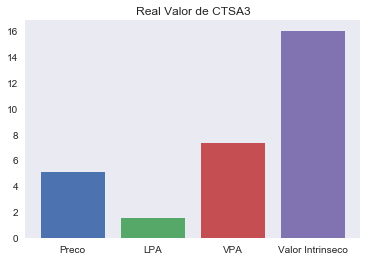

In [88]:
plt.bar('Preco', FundReport['Preco'], label='Preco')
plt.bar('LPA', FundReport['LPA'], label='Lucro Por Ação')
plt.bar('VPA', FundReport['VPA'], label='Valor Por Ação')
plt.bar('Valor Intrinseco', FundReport['Valor Intrinseco'], label='Valor Intrinseco')

plt.title(f'Real Valor de {ticker}')

#plt.legend()

plt.show()

In [91]:
print(f'- Lote de 100 ({ticker}) -\nPreço de Compra : {Preco * 100:.2f}\nLucro no Alvo : {(VIntrinseco - Preco) * 100:.2f}\nCash Final : {(Preco + (VIntrinseco - Preco)) * 100:.2f}\nLucro Anual por Lote : {LPA * 100:0.2f}')

- Lote de 100 (CTSA3) -
Preço de Compra : 511.00
Lucro no Alvo : 1088.62
Cash Final : 1599.62
Lucro Anual por Lote : 156.00
